In [ ]:
!cd ../
!rm -rf NUMERAI
!git clone -b dev_baselinemodel https://github.com/ryuji-hashimoto0110/NUMERAI.git

In [ ]:
!pip install tensorboardX

In [23]:
import sys
sys.path.append('/content/NUMERAI')

In [31]:
from utils.preprocess import make_traintest_data, choose_features
from utils.diagnosis import calc_spearman_corr, mean_rank
from models import BaseLineModel
from train import train
from submit import submit

In [5]:
import pathlib
import numpy as np
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import tensorboardX as tbx

%matplotlib inline

In [6]:
root_path = pathlib.Path('/content/drive/My Drive/NUMERAI')

In [7]:
train_data, test_data, feature_names, test_id = make_traintest_data(root_path,
                                                                    'numerai_datasets_round277')

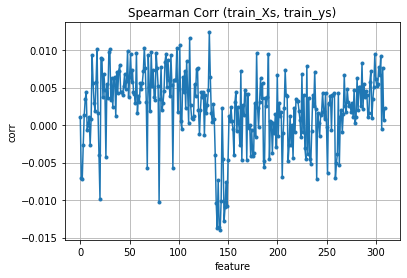

In [9]:
target = train_data['target'].values
features = train_data[feature_names].values
corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                           arr=features, y=target)
fig, ax = plt.subplots()
ax.grid()
ax.plot(corr_arr,
        marker='.', markersize=6)
ax.set_title('Spearman Corr (train_Xs, train_ys)')
ax.set(xlabel='feature', ylabel='corr')
plt.show()

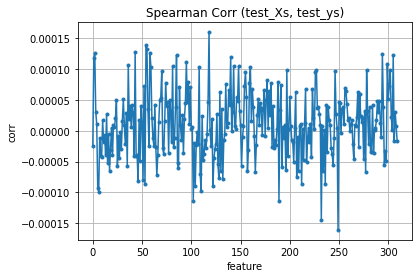

In [10]:
target = test_data['target'].values
features = test_data[feature_names].values
corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                               arr=features, y=target)
fig, ax = plt.subplots()
ax.grid()
ax.plot(corr_arr,
        marker='.', markersize=6)
ax.set_title('Spearman Corr (test_Xs, test_ys)')
ax.set(xlabel='feature', ylabel='corr')
plt.show()

In [8]:
highcorr_idx, highcorr_arr = choose_features(train_data, feature_names, 0.005)
highcorr_features = [feature_names[int(idx)] for idx in highcorr_idx[0]]
train_Xs = train_data[highcorr_features].values
train_ts = train_data['target'].values
test_Xs = test_data[highcorr_features].values
test_ts = test_data['target'].values
test_corr_arr = np.apply_along_axis(calc_spearman_corr, axis=0, 
                                    arr=test_Xs, y=test_ts)
print('Corr between feature and target (train/test)')
for i in range(len(highcorr_features)):
    feature = highcorr_features[i]
    train_corr = highcorr_arr[i]
    test_corr = test_corr_arr[i]
    print(f'[feature]{feature} [corr]({train_corr:.6f}/{test_corr:.6f})')

Corr between feature and target (train/test)
[feature]feature_charisma1 [corr](0.009310/-0.000007)
[feature]feature_charisma2 [corr](0.005661/-0.000039)
[feature]feature_charisma5 [corr](0.005696/-0.000005)
[feature]feature_charisma6 [corr](0.010077/-0.000065)
[feature]feature_charisma10 [corr](0.008991/0.000009)
[feature]feature_charisma11 [corr](0.008782/0.000006)
[feature]feature_charisma13 [corr](0.006794/0.000050)
[feature]feature_charisma16 [corr](0.005490/-0.000044)
[feature]feature_charisma18 [corr](0.009736/-0.000029)
[feature]feature_charisma19 [corr](0.010115/0.000016)
[feature]feature_charisma21 [corr](0.006236/0.000009)
[feature]feature_charisma23 [corr](0.006226/0.000029)
[feature]feature_charisma24 [corr](0.006398/-0.000057)
[feature]feature_charisma26 [corr](0.007098/0.000020)
[feature]feature_charisma28 [corr](0.007219/0.000006)
[feature]feature_charisma29 [corr](0.007980/0.000041)
[feature]feature_charisma33 [corr](0.005262/-0.000042)
[feature]feature_charisma34 [corr

In [44]:
class dfDataset(Dataset):
    def __init__(self, Xs, ts, transforms=None):
        self.Xs = Xs
        self.ts = ts
        self.transforms = transforms
        
    def __len__(self):
        return len(self.Xs)
    
    def __getitem__(self, index):
        x = torch.from_numpy(self.Xs[index,:].astype(np.float32))
        t = torch.from_numpy(self.ts[index].reshape(1,1).astype(np.float32))
        if self.transforms is not None:
            x, t = self.transforms(x,t)
        return x, t

[device]cuda
[fold]1/5
[train_n]401446 [val_n]100362
[epoch]1/22 [loss]tra:0.0631 val:0.0509 [corr]tra:0.01906099 val:0.02447776 [time]total:8.62sec tra:7.280782222747803sec val:1.3424532413482666sec
[epoch]2/22 [loss]tra:0.0503 val:0.0500 [corr]tra:0.01941227 val:0.01894773 [time]total:8.81sec tra:7.192831754684448sec val:1.6184234619140625sec
[epoch]3/22 [loss]tra:0.0500 val:0.0499 [corr]tra:0.01912056 val:0.01869628 [time]total:8.54sec tra:7.048655986785889sec val:1.493959665298462sec
[epoch]4/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.01781212 val:0.01445023 [time]total:8.71sec tra:6.835376024246216sec val:1.872899055480957sec
[epoch]5/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.02038130 val:0.02469197 [time]total:8.82sec tra:6.883974313735962sec val:1.9329087734222412sec
[epoch]6/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.01894345 val:0.02523738 [time]total:8.76sec tra:6.872037649154663sec val:1.8856267929077148sec
[epoch]7/22 [loss]tra:0.0499 val:0.0498 [corr]tra:0.01995295 val:0.

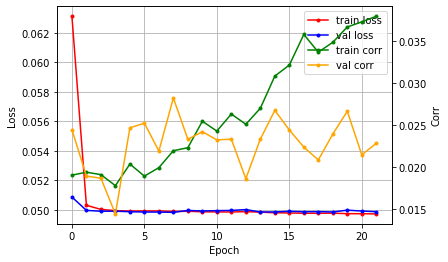

[fold]2/5
[train_n]401446 [val_n]100362
[epoch]1/22 [loss]tra:0.0572 val:0.0505 [corr]tra:0.02080928 val:0.02012744 [time]total:8.85sec tra:7.391050338745117sec val:1.4600446224212646sec
[epoch]2/22 [loss]tra:0.0502 val:0.0501 [corr]tra:0.01982559 val:0.02117385 [time]total:9.15sec tra:7.476729393005371sec val:1.6744482517242432sec
[epoch]3/22 [loss]tra:0.0500 val:0.0503 [corr]tra:0.02068976 val:0.01184209 [time]total:9.48sec tra:7.662718296051025sec val:1.812554121017456sec
[epoch]4/22 [loss]tra:0.0499 val:0.0501 [corr]tra:0.02003505 val:0.01926081 [time]total:9.42sec tra:7.587592601776123sec val:1.8303711414337158sec
[epoch]5/22 [loss]tra:0.0499 val:0.0504 [corr]tra:0.02085604 val:0.02038098 [time]total:9.56sec tra:7.559743642807007sec val:2.000227928161621sec
[epoch]6/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.02093607 val:0.01879226 [time]total:9.31sec tra:7.763143301010132sec val:1.5517373085021973sec
[epoch]7/22 [loss]tra:0.0499 val:0.0502 [corr]tra:0.02476315 val:0.01965396 [tim

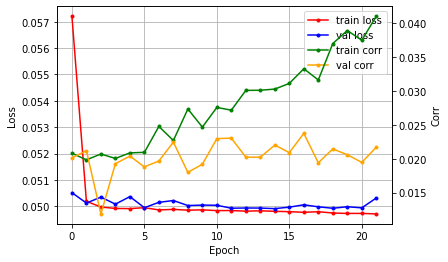

[fold]3/5
[train_n]401446 [val_n]100362
[epoch]1/22 [loss]tra:0.0542 val:0.0506 [corr]tra:0.02155930 val:0.02568762 [time]total:9.50sec tra:7.63641619682312sec val:1.8663427829742432sec
[epoch]2/22 [loss]tra:0.0502 val:0.0501 [corr]tra:0.02162124 val:0.02572447 [time]total:9.56sec tra:7.884662389755249sec val:1.6762375831604004sec
[epoch]3/22 [loss]tra:0.0500 val:0.0499 [corr]tra:0.02041147 val:0.02690230 [time]total:9.13sec tra:7.554378032684326sec val:1.5787296295166016sec
[epoch]4/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.02287614 val:0.02405627 [time]total:9.39sec tra:7.76421594619751sec val:1.6295220851898193sec
[epoch]5/22 [loss]tra:0.0499 val:0.0499 [corr]tra:0.02120331 val:0.02795410 [time]total:9.31sec tra:7.822919607162476sec val:1.4881236553192139sec
[epoch]6/22 [loss]tra:0.0498 val:0.0499 [corr]tra:0.02292094 val:0.02671867 [time]total:9.36sec tra:7.646278142929077sec val:1.7112350463867188sec
[epoch]7/22 [loss]tra:0.0498 val:0.0499 [corr]tra:0.02459380 val:0.02578963 [tim

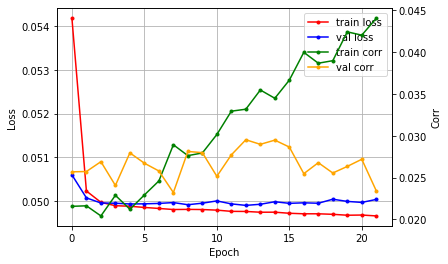

[fold]4/5
[train_n]401447 [val_n]100361
[epoch]1/22 [loss]tra:0.0516 val:0.0498 [corr]tra:0.02146832 val:0.02421623 [time]total:9.31sec tra:7.7481091022491455sec val:1.5662047863006592sec
[epoch]2/22 [loss]tra:0.0500 val:0.0496 [corr]tra:0.02434335 val:0.02460657 [time]total:9.39sec tra:7.929887533187866sec val:1.4632339477539062sec
[epoch]3/22 [loss]tra:0.0499 val:0.0496 [corr]tra:0.02462688 val:0.02610043 [time]total:9.24sec tra:7.50028133392334sec val:1.7362761497497559sec
[epoch]4/22 [loss]tra:0.0499 val:0.0496 [corr]tra:0.02677941 val:0.02422479 [time]total:9.40sec tra:7.5984179973602295sec val:1.805387020111084sec
[epoch]5/22 [loss]tra:0.0499 val:0.0495 [corr]tra:0.02679092 val:0.02810289 [time]total:9.38sec tra:7.42479681968689sec val:1.9569263458251953sec
[epoch]6/22 [loss]tra:0.0499 val:0.0496 [corr]tra:0.02628480 val:0.02545678 [time]total:9.01sec tra:7.507523536682129sec val:1.5066306591033936sec
[epoch]7/22 [loss]tra:0.0499 val:0.0496 [corr]tra:0.02952669 val:0.02510464 [ti

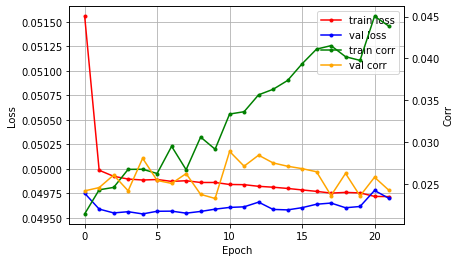

[fold]5/5
[train_n]401447 [val_n]100361
[epoch]1/22 [loss]tra:0.0629 val:0.0517 [corr]tra:0.02155701 val:0.02378925 [time]total:9.75sec tra:7.993063688278198sec val:1.7598798274993896sec
[epoch]2/22 [loss]tra:0.0506 val:0.0504 [corr]tra:0.02362128 val:0.02136180 [time]total:9.49sec tra:8.028448820114136sec val:1.462895154953003sec
[epoch]3/22 [loss]tra:0.0500 val:0.0501 [corr]tra:0.02161533 val:0.02471407 [time]total:10.31sec tra:8.429542064666748sec val:1.8797459602355957sec
[epoch]4/22 [loss]tra:0.0499 val:0.0501 [corr]tra:0.02169569 val:0.02543345 [time]total:9.81sec tra:8.085469961166382sec val:1.72133207321167sec
[epoch]5/22 [loss]tra:0.0499 val:0.0500 [corr]tra:0.01844717 val:0.02591479 [time]total:10.10sec tra:8.054362773895264sec val:2.0450215339660645sec
[epoch]6/22 [loss]tra:0.0499 val:0.0501 [corr]tra:0.01928332 val:0.01899492 [time]total:9.69sec tra:8.201505899429321sec val:1.4887418746948242sec
[epoch]7/22 [loss]tra:0.0499 val:0.0503 [corr]tra:0.02096525 val:0.02544958 [ti

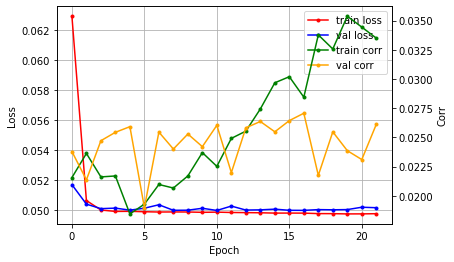

In [45]:
model_class = BaseLineModel
dataset_class = dfDataset
model_name = 'BaseLineModel'
checkpoints_path = root_path / 'checkpoints'
log_dir = root_path / 'log' / 'baselinemodel_round277'
FOLD_N = 5
NUM_EPOCH = 22
input_dim = train_Xs.shape[1]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transforms = None
criterion = nn.MSELoss()

train_models, train_model_paths = train(model_class, dataset_class, 
                                        model_name, checkpoints_path, log_dir,
                                        FOLD_N, NUM_EPOCH, input_dim, device, transforms,
                                        train_Xs, train_ts,
                                        criterion)

- lossは下げ止まり．
- Corrはtrainは上がるがvalidはほぼ横ばい．

In [49]:
submit(train_models, test_Xs, test_ts, dataset_class, test_id, device, 
       transforms, root_path, 'numerai_datasets_round277')

## 結果
- Validation Sharpe...The mean of your per-era correlation devided by the standard deviation of your per-era correlation. (eraごとの順位相関の平均値をeraごとの順位相関の標準偏差で割ったもの．1以上だと優秀らしい．)：0.5859
- Validation Corr...The mean of your per-era correlation. (eraごとの順位相関の平均値．0.025以上だと優秀)：0.0145

## 考察

今回はeraを全く使わずに作ったモデルだったため，Validation Sharp, Validation Corrは共に低かった．今後はeraをどう扱うかが課題となりそう．